In [1]:
from tensorflow.keras.layers import Conv2D, Flatten ,Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib as plt
import numpy as np

In [2]:
img_height, img_width = (360, 360)
batch_size = 32

train_data_dir = r'C:/Users/Carlos/Desktop/doggy/processed/train'
valid_data_dir = r'C:/Users/Carlos/Desktop/doggy/processed/val'
test_data_dir = r'C:/Users/Carlos/Desktop/doggy/processed/test'

In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True, 
    validation_split = 0.4)

train_generator = train_datagen.flow_from_directory(
    train_data_dir, 
    target_size = (img_height, img_width), 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    subset = 'training') # set as a training data

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir, 
    target_size = (img_height, img_width), 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    subset = 'validation') # set as validation data


Found 90 images belonging to 5 classes.
Found 20 images belonging to 5 classes.


In [4]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir, # same directory as training data
    target_size = (img_height, img_width), 
    batch_size = 1, 
    class_mode = 'categorical', 
    subset = 'validation') #set as validation data

Found 20 images belonging to 5 classes.


In [5]:
x,y = test_generator.next()
x.shape

(1, 360, 360, 3)

In [6]:
base_model = ResNet50(include_top = False, weights = 'imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(train_generator.num_classes, activation = 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(train_generator, epochs = 10)

Epoch 1/10
3/3 [==============================] - 9s 3s/step - loss: 2.5310 - accuracy: 0.2556
Epoch 2/10
3/3 [==============================] - 10s 3s/step - loss: 0.8200 - accuracy: 0.7222
Epoch 3/10
3/3 [==============================] - 9s 3s/step - loss: 0.3898 - accuracy: 0.8333
Epoch 4/10
3/3 [==============================] - 11s 4s/step - loss: 0.0906 - accuracy: 0.9667
Epoch 5/10
3/3 [==============================] - 10s 3s/step - loss: 0.0748 - accuracy: 0.9778
Epoch 6/10
3/3 [==============================] - 10s 3s/step - loss: 0.0498 - accuracy: 0.9889
Epoch 7/10
3/3 [==============================] - 10s 3s/step - loss: 0.0322 - accuracy: 0.9889
Epoch 8/10
3/3 [==============================] - 10s 3s/step - loss: 0.0106 - accuracy: 1.0000
Epoch 9/10
3/3 [==============================] - 12s 4s/step - loss: 0.0088 - accuracy: 1.0000
Epoch 10/10
3/3 [==============================] - 10s 3s/step - loss: 0.0031 - accuracy: 1.0000


In [7]:
model.save('C:/Users/Carlos/Desktop/doggy/model/ResNet50_doggy.h5')

In [8]:
test_loss, test_acc = model.evaluate(test_generator, verbose = 2)
print('\nTset accuracy:', test_acc)

20/20 - 3s - loss: 0.0073 - accuracy: 1.0000

Tset accuracy: 1.0


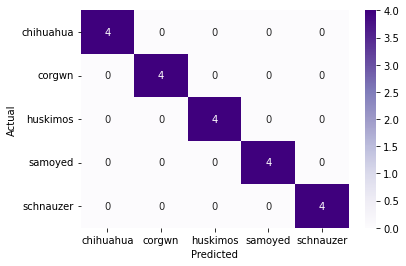

test accuracy : 100.0


In [9]:
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('C:/Users/Carlos/Desktop/doggy/model/ResNet50_doggy.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob = []
y_act = []
test_generator.reset()
for _ in range(nb_samples):
    X_test, Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns = ['predicted_class', 'actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames = ['Actual'], colnames = ['Predicted'])

sn.heatmap(confusion_matrix, cmap = 'Purples', annot = True, fmt = 'd')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))